In [1]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools 
import datetime

import cv2
import os
import io

In [2]:

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 150*150.
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images into range 0 to 1.
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:17<00:00, 16.92it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


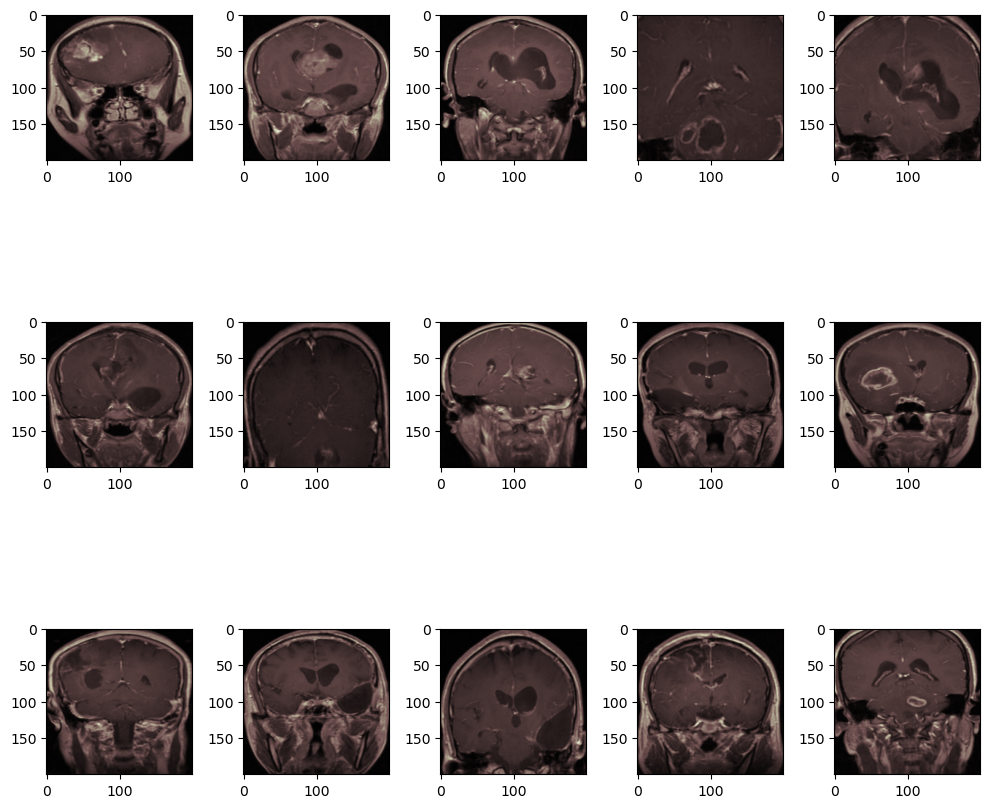

In [6]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [8]:

x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tf.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tf.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)
...

MemoryError: Unable to allocate 5.11 GiB for an array with shape (5712, 200, 200, 3) and data type float64

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [ ]:
inceptionV3 = tf.keras.applications.inception_v3.InceptionV3(
     weights='imagenet',
    include_top=False, 
    input_shape=(image_size,image_size,3)
)

In [ ]:

model_inceptionV3 = inceptionV3.output
model_inceptionV3 = GlobalAveragePooling2D()(model_inceptionV3)
model_inceptionV3 = Dropout(0.4)(model_inceptionV3)
model_inceptionV3= Dense(4, activation="softmax")(model_inceptionV3)
model_inceptionV3 = Model(inputs= inceptionV3.input, outputs= model_inceptionV3)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model_inceptionV3.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model_inceptionV3.summary()

In [ ]:


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint_inceptionV3 = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES_inceptionV3 = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL_inceptionV3 = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks_inceptionV3 = [ES_inceptionV3,RL_inceptionV3,Checkpoint_inceptionV3]

history_inceptionV3 = model_inceptionV3.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_val,y_val),epochs = EPOCHS,callbacks = callbacks_inceptionV3)

In [ ]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_inceptionV3.history['loss'],'r',linewidth=3.0)
plt.plot(history_inceptionV3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_inceptionV3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history_inceptionV3.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

In [ ]:
predicted_classes_inceptionV3 = np.argmax(model_inceptionV3.predict(x_test), axis = 1)
confusionmatrix_inceptionV3 = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes_inceptionV3)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix_inceptionV3, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes_inceptionV3))


In [ ]:
loss,acc = model_inceptionV3.evaluate(x_test,y_test)